# Task: Using CNN to get high quality dog dataset

In this notebook, we will walk through the steps to get actual dog 
images from the frames one get with scene detection. The goal is get 
high quality dog images, ready for the purpose of training for the
anxiety classification task. We will use a CNN to achieve this goal.

Note the default environment is on Jupyter Notebook, but some slight 
modification will enable it to be executed on local python.We use Google Drive for the storage of our original data.

---






# Step 0: Import Dataset
We first connect to our drive.

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


Before we started, we need to rename our initial files for better 
processing.

In [5]:
import os
def RenameFiles(folder):
  count = 1
  # count increase by 1 in each iteration
  # iterate all files from a directory
  for file_name in os.listdir(folder):
    # Construct old file name
    source = folder + file_name

    # Adding the count to the new file name and extension
    destination = folder + "image_" + str(count) + ".jpg"

    # Renaming the file
    os.rename(source, destination)
    count += 1
  print('All Files Renamed')

  print('New Names are')
  # verify the result
  res = os.listdir(folder)
  print(res)

folder = '/content/drive/MyDrive/Dog anxiety Dataset /scene detect/video/'
RenameFiles(folder)

All Files Renamed
New Names are
['image_1.jpg', 'image_2.jpg', 'image_3.jpg', 'image_4.jpg', 'image_5.jpg', 'image_6.jpg', 'image_7.jpg', 'image_8.jpg', 'image_9.jpg', 'image_10.jpg', 'image_11.jpg', 'image_12.jpg', 'image_13.jpg', 'image_14.jpg', 'image_15.jpg', 'image_16.jpg', 'image_17.jpg', 'image_18.jpg', 'image_19.jpg', 'image_20.jpg', 'image_21.jpg', 'image_22.jpg', 'image_23.jpg', 'image_24.jpg', 'image_25.jpg', 'image_26.jpg', 'image_27.jpg', 'image_28.jpg', 'image_29.jpg', 'image_30.jpg', 'image_31.jpg', 'image_32.jpg', 'image_33.jpg', 'image_34.jpg', 'image_35.jpg', 'image_36.jpg', 'image_37.jpg', 'image_38.jpg', 'image_39.jpg', 'image_40.jpg', 'image_41.jpg', 'image_42.jpg', 'image_43.jpg', 'image_44.jpg', 'image_45.jpg', 'image_46.jpg', 'image_47.jpg', 'image_48.jpg', 'image_49.jpg', 'image_50.jpg', 'image_51.jpg', 'image_52.jpg', 'image_53.jpg', 'image_54.jpg', 'image_55.jpg', 'image_56.jpg', 'image_57.jpg', 'image_58.jpg', 'image_59.jpg', 'image_60.jpg', 'image_61.jpg', 

We can now try to plot the original data we have and have some 
idea about how they look like.


Visualization of original data



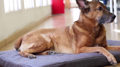
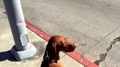
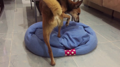
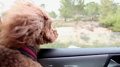
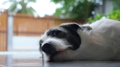
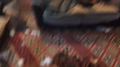
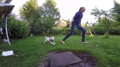
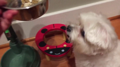
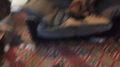
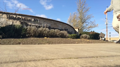
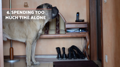
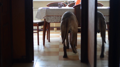
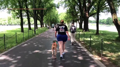
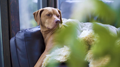
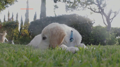
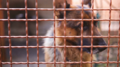
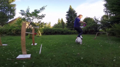
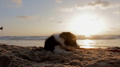
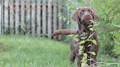
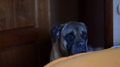


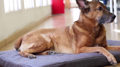
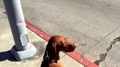
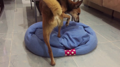
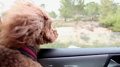
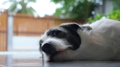
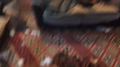
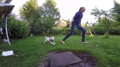
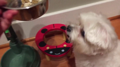
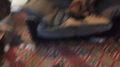
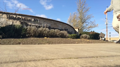
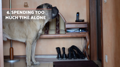
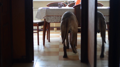
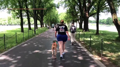
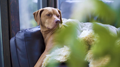
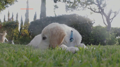
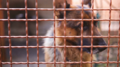
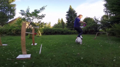
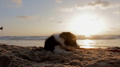
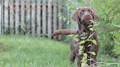
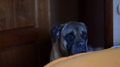

In [6]:
!pip install ipyplot -qq
import ipyplot
from PIL import Image
import numpy as np
from numpy.core.defchararray import replace

np.random.seed(111)

num_img = 20
a = np.arange(200)
# We make sure zero is not included
# as we start our file renaming with 1
a = a+1
index = np.random.choice(a, size = num_img, replace = False) 
imgs = [Image.open(folder + 'image_'+ str(x) +'.jpg')
               for x in index]

print("Visualization of original data")
ipyplot.plot_images(imgs, max_images=num_img, img_width=120)


As we can see, not all frames contain a dog inside. Some frames
are irrelevant intermediate scece that we have to remove.

# Step 1: Detect Dogs

P.S. The following section borrows idea from [Udacity's CNN project](https://github.com/udacity/dog-project).


In this section, we use a pre-trained [ResNet-50](https://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](https://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


# Preprocess our data

The `path_to_tensor` function below takes a string-valued file path to 
a color image as input and returns a 4D tensor suitable for supplying 
to a Keras CNN. The function first loads the image and resizes it 
to a square image that is $224 \times 224$ pixels. Next, the image 
is converted to an array, which is then resized to a 4D tensor. 
In this case, since we are working with color images, each image has 
three channels. Likewise, since we are processing a single image 
(or sample), the returned tensor will always have shape

\begin{align}
(1,224,224,3)
\end{align}

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape
\begin{align}
(\text{nb_samples},224,224,3)
\end{align}
where `nb_samples` are the number of samples supplied with the give 
sample paths.

In [8]:
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939,116.779,123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function `preprocess_input`. If you're curious, you can check the code [here](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py) .

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the predict method, which returns an array whose i-th entry is the model's predicted probability that the image belongs to the i-th ImageNet category. This is implemented in the ResNet50_predict_labels function below.

In [9]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return ResNet50_model.predict(img)

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the ResNet50_predict_labels function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, threshold = 0.5):
    prediction = ResNet50_predict_labels(img_path)
    # only returns the prediction if the first prediction has 
    # probability greater than threshold (default is 0.5).
    if np.max(prediction) < threshold:
      return False
    top = np.argmax(prediction)
    return ((top <= 268) & (top >= 151)) 

Before we can work with our images, we need a helper function that retrieves paths to individual images from a given path. 

In [11]:
import os
def getListOfFiles(foldername):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(foldername)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(foldername, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles



We are now ready to use our dog detector function

In [14]:
### Try the dog_detector function
### on the images from one video in our dataset.

def foldername_to_image(foldername):
  count_dog = 0  
  img_path = getListOfFiles(foldername)
  num_img = len(img_path)
  paths = [] 
  for i in range(num_img):
    path = img_path[i]
    if dog_detector(path) == True:
        count_dog += 1
        paths.append(path)
        # The follow block is to give a sense of how our
        # model is performing by showing the actual image and
        # the result.It can be used on negatives as well.

        #img = image.load_img(path, target_size=(224, 224))
        #plt.imshow(img)
        #plt.axis('off')
        #plt.show()
        #preds = ResNet50_predict_labels(path)
        #print("predicted:", decode_predictions(preds, top=3)[0])

  print('%.1f%% of the images have detected dog' %(100 * count_dog/num_img))
  return paths

folder = '/content/drive/MyDrive/Dog anxiety Dataset /scene detect/video'
paths = foldername_to_image(folder)


30.2% of the images have detected dog


# Step 2： Moving obtained images into one folder
We now move those images with dogs into a folder and rename them 
before viewing.

In [19]:
import shutil
def moveListOfFiles(paths,new_folder):
  count = 1
  # count increase by 1 in each iteration
  # iterate all files from a directory
  for file_name in paths:
    # Construct old file name
    source = file_name

    # Adding the count to the new file name and extension
    destination = new_folder + "image_" + str(count) + ".jpg"

    # Renaming the file
    shutil.copy(source, destination)
    count += 1
  print('All Files Renamed')

  print('New Names are')
  # verify the result
  res = os.listdir(new_folder)
  print(res)

new_folder = '/content/drive/MyDrive/Dog anxiety Dataset /Data/anxiety/'
moveListOfFiles(paths,new_folder)



All Files Renamed
New Names are
['image_1.jpg', 'image_2.jpg', 'image_3.jpg', 'image_4.jpg', 'image_5.jpg', 'image_6.jpg', 'image_7.jpg', 'image_8.jpg', 'image_9.jpg', 'image_10.jpg', 'image_11.jpg', 'image_12.jpg', 'image_13.jpg', 'image_14.jpg', 'image_15.jpg', 'image_16.jpg', 'image_17.jpg', 'image_18.jpg', 'image_19.jpg', 'image_20.jpg', 'image_21.jpg', 'image_22.jpg', 'image_23.jpg', 'image_24.jpg', 'image_25.jpg', 'image_26.jpg', 'image_27.jpg', 'image_28.jpg', 'image_29.jpg', 'image_30.jpg', 'image_31.jpg', 'image_32.jpg', 'image_33.jpg', 'image_34.jpg', 'image_35.jpg', 'image_36.jpg', 'image_37.jpg', 'image_38.jpg', 'image_39.jpg', 'image_40.jpg', 'image_41.jpg', 'image_42.jpg', 'image_43.jpg', 'image_44.jpg', 'image_45.jpg', 'image_46.jpg', 'image_47.jpg', 'image_48.jpg', 'image_49.jpg', 'image_50.jpg', 'image_51.jpg', 'image_52.jpg', 'image_53.jpg', 'image_54.jpg', 'image_55.jpg', 'image_56.jpg', 'image_57.jpg', 'image_58.jpg', 'image_59.jpg', 'image_60.jpg', 'image_61.jpg', 

# Step 3: Show some results

Show some images for anxious dogs

Anxious dogs



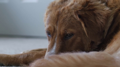
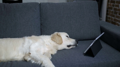
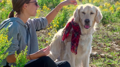
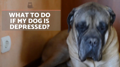
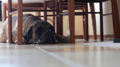
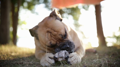
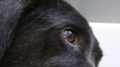
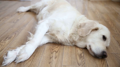
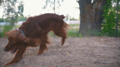
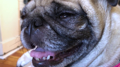
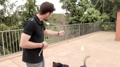
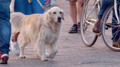
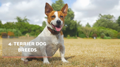
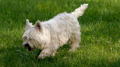
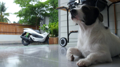
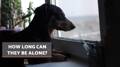
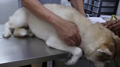
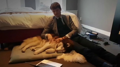
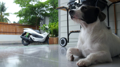
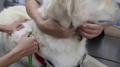


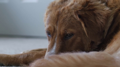
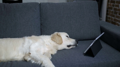
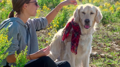
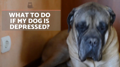
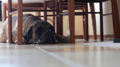
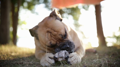
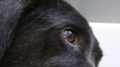
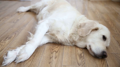
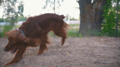
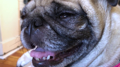
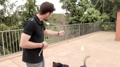
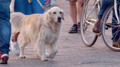
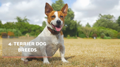
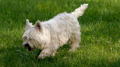
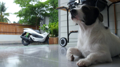
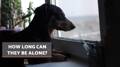
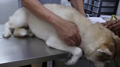
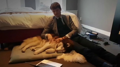
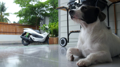
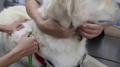

In [18]:
new_folder = '/content/drive/MyDrive/Dog anxiety Dataset /Data/anxiety/'
folder = new_folder
num_img = 20

np.random.seed(111)

a = np.arange(200)
# We make sure zero is not included
# as we start our file renaming with 1
a = a+1
index = np.random.choice(a, size = num_img, replace = False) 
good_img = [Image.open(folder + 'image_'+ str(x) +'.jpg')
               for x in index]

print("Anxious dogs")
ipyplot.plot_images(good_img, max_images=num_img, img_width=120)



We now repeat the above process with happy dogs and plot some results.

44.1% of the images have detected dog
All Files Renamed
New Names are
['image_1.jpg', 'image_2.jpg', 'image_3.jpg', 'image_4.jpg', 'image_5.jpg', 'image_6.jpg', 'image_7.jpg', 'image_8.jpg', 'image_9.jpg', 'image_10.jpg', 'image_11.jpg', 'image_12.jpg', 'image_13.jpg', 'image_14.jpg', 'image_15.jpg', 'image_16.jpg', 'image_17.jpg', 'image_18.jpg', 'image_19.jpg', 'image_20.jpg', 'image_21.jpg', 'image_22.jpg', 'image_23.jpg', 'image_24.jpg', 'image_25.jpg', 'image_26.jpg', 'image_27.jpg', 'image_28.jpg', 'image_29.jpg', 'image_30.jpg', 'image_31.jpg', 'image_32.jpg', 'image_33.jpg', 'image_34.jpg', 'image_35.jpg', 'image_36.jpg', 'image_37.jpg', 'image_38.jpg', 'image_39.jpg', 'image_40.jpg', 'image_41.jpg', 'image_42.jpg', 'image_43.jpg', 'image_44.jpg', 'image_45.jpg', 'image_46.jpg', 'image_47.jpg', 'image_48.jpg', 'image_49.jpg', 'image_50.jpg', 'image_51.jpg', 'image_52.jpg', 'image_53.jpg', 'image_54.jpg', 'image_55.jpg', 'image_56.jpg', 'image_57.jpg', 'image_58.jpg', 'image_59.


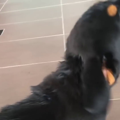
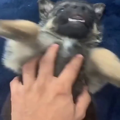
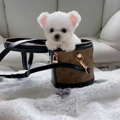
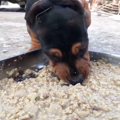
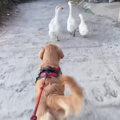
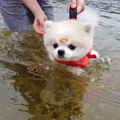
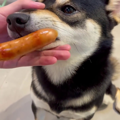
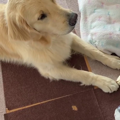
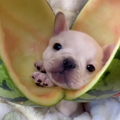
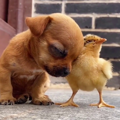
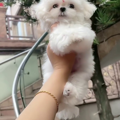
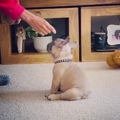
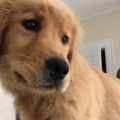
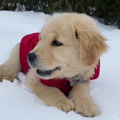
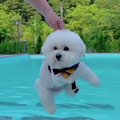
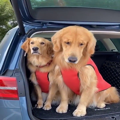
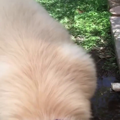
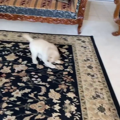
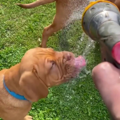
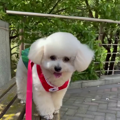


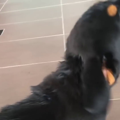
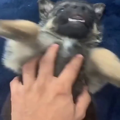
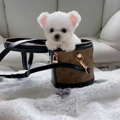
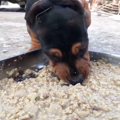
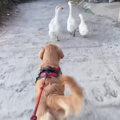
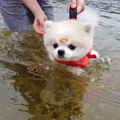
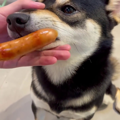
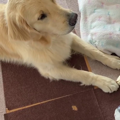
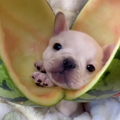
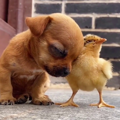
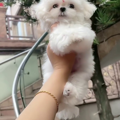
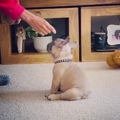
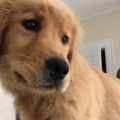
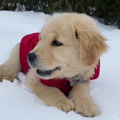
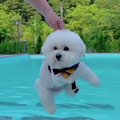
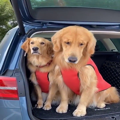
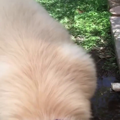
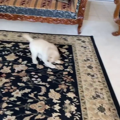
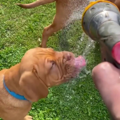
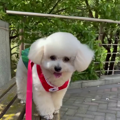

In [23]:
# Get image paths with dog detector
folder = '/content/drive/MyDrive/Dog anxiety Dataset /Data/Pos'
paths = foldername_to_image(folder)

# Move images into a new folder
new_folder = '/content/drive/MyDrive/Dog anxiety Dataset /Data/normal/'
moveListOfFiles(paths,new_folder)

folder = new_folder
num_img = 20
a = np.arange(len(paths))
# We make sure zero is not included
# as we start our file renaming with 1
a = a+1
index = np.random.choice(a, size = num_img, replace = False)
happy_img = [Image.open(folder  + 'image_'+ str(x) +'.jpg')
               for x in index]

print("Happy dogs")
ipyplot.plot_images(happy_img, max_images=num_img, img_width=120)